# ASDI Demo Cases - Using TAP and a MAST API

This notebook shows how to use a TAP service to download pristine synthetic data from the MAST archive, and a second service that performs instrument simulations on that data server-side.

***
## Imports

In [1]:
# Use the astroquery TapPlus library as our client to the data service.
from astroquery.utils.tap.core import TapPlus

# For handling ordinary astropy Tables in responses
from astropy.table import Table

# For data simulation steps
import asdi_datasim

# For displaying and manipulating some types of results
import astropy
import time
import numpy as np
import astropy.io.fits as fits
import requests
import os
from zipfile import ZipFile 

#plotting routines
import matplotlib
from matplotlib import pyplot

## TAP Service Introduction

Table Access Protocol (TAP) services allow more direct and flexible access to astronomical data than the simpler types of IVOA standard data services. Queries are built with the SQL-like Astronomical Data Query Language (ADQL), and can include geographic / spatial queries as well as filtering on other characteristics of the data. This also allows the user fine-grained control over the returned columns, unlike the fixed set of coumns retunred from cone, image, and spectral services.

For this example, we'll be using the astroquery TAP/TAP+ client, which was developed by the ESAC Space Data Centre for working with the GAIA catalog, but is interoperable with other valid TAP services, including those at MAST. As an astroquery project, TAP+ documentation is available at ReadTheDocs: http://astroquery.readthedocs.io/en/latest/utils/tap.html

## Service Specific Configuration

Every TAP service has a "Base URL" plus associated endpoints for synchronous and asynchronous queries, as well as status and capability information, and sometimes service-provided sample queries. The endpoints are predefined in the TAP standard, so clients can infer them using the base. We therefore only have to provide astroquery that base.

In [2]:
TAP_URL = "http://vaotest.stsci.edu/ASDI/tapservice.aspx"

## Connecting to the Service

The TapPlus library is able to connect to any TAP service, given the "base" URL as noted in metadata registry resources describing the service. The CAOM TAP service at MAST has access to TESS FFI and time series, including file URLs for download.

In [3]:
TAP_service = TapPlus(url=TAP_URL)

Created TAP+ (v1.0.1) - Connection:
	Host: vaotest.stsci.edu
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### Browsing the Schema

TAP gives us access to descriptive metadata for this catalog. We can use this to narrow searches and filter our results. For the current catalog, there is only one table, with columns for the project name, nullable fields relevant to various projects, and a public path for downloading associated files.

In [4]:
table_descriptions = TAP_service.load_tables()
print('\n')
for table in table_descriptions:
    if(not table.name.startswith('tap_schema')):
        print('TAP table: ' + table.name)
        print(table.description)
        print('\n')
        for i, column in enumerate(table.columns):
            print(column.name)
            print(column.description)
            print('\n')

Retrieving tables...
Parsing tables...
Done.


TAP table: dbo.ASDISpectra1dCGM
A view created by joining the HLSPASDISpectra1dCGMProduct table (file-level information) with HLSPASDISpectra1dCGMLine table (spectral line-level information)


lineName
Name of the transition associated with this spectral feature. Available entries: 'C IV 1548', 'H I 1216', 'H I 919', 'O VI 1032', 'Si II 1260', 'Si IV 1394'


restWave
Rest-frame wavelength


physIonDensity
Ionic column-density-weighted density


totalColumn
Total column number density of this ion. Units are log cm^-2.


physIonTemperature
Ionic column-density-weighted temperature


physIonMetallicity
Ionic column-density-weighted metallicity, in units of solar metallicity


projectName
Name of the simulation suite. Available entries: 'foggie'


physicsName
Name of the physics set assumed for these simulations. Available entries: 'nref11n-nref10f'


seriesName
Name of the simulation series (for example, name of the halo evolved over time). A

***
# ASDI CGM Use Case 1
Search for simulated CGM sightlines at 0.3 < z < 1.5 with HI, OVI, and NeVIII absorption. To compare with our own data, we wants only sightlines with OVI column density > 10^12.75 cm-2.

We remotely search two catalogs with redshifts, HI, OVI, and NeVIII column densities, impact parameters, galaxy stellar masses, and galaxy star formation rates, one from the FOGGIE simulations and one from the FIRE simulations.

Modifications/Simplifications for Demo:  z=2, 2.5 only; FOGGIE only, no NeVIII yet (replace with C IV)

In [5]:
# First we search FOGGIE. Note that we don't need every column returned; we can filter server-side
job = TAP_service.launch_job("""
            SELECT lineName, extNum, redshift, totalColumn, impact, mstar, sfr, publicPath 
            FROM dbo.ASDISpectra1DCGM 
            WHERE projectName = 'foggie' AND
            (lineName = 'O VI 1032' OR lineName = 'Si II 1260') AND
            (redshift >= 1.8 and redshift <= 2.5) AND
            totalColumn >= 12.75
            """)

foggie_results = job.get_results()
foggie_results

lineName,extNum,redshift,totalColumn,impact,mstar,sfr,publicPath
,number,dimensionless,log cm^-2,physical kpc,msun,msun per year,
bytes36,float32,float64,float32,object,float32,float32,bytes250
O VI 1032,7.0,2.4999995,13.34705,40.175870626938568364,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.6-dz066.6_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,13.37358,39.19119058176030279,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.7-dz065.1_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,13.08275,32.25114087847141775,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy005.9-dz033.6_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,13.03269,43.044143055335069903,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.4-dz071.8_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,12.75337,47.242586779792787866,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.6-dz077.7_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,13.37122,32.295115754447479617,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy006.9-dz030.3_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,14.23466,29.872306775578138627,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy007.5-dz037.7_v1_pristine-los.fits
O VI 1032,7.0,2.4999995,13.45826,32.08608726285338264,2.5,1100000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0018/axx/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0018-axx-dy008.6-dz026.9_v1_pristine-los.fits


***
# ASDI CGM Use Case 2
We search for simulated CGM sightlines with SiII, SiIII, SiIV, OVI, and NeVIII absorption. We page through a few of the quicklooks and pick a few sightlines that look interesting, then download the FITS files with optical depth and normalized flux versus velocity at the intrinsic simulation resolution with no noise added, and at the STIS/E140H and COS/G130M (both LP1 and LP4) resolution, each with S/N=5, 10, 20, 50, 100 per resel applied. We can then download the individual files.

In [6]:
np.random.seed(0)
interesting_los=foggie_results[np.random.randint(0,len(foggie_results),3)]

interesting_los

lineName,extNum,redshift,totalColumn,impact,mstar,sfr,publicPath
,number,dimensionless,log cm^-2,physical kpc,msun,msun per year,
bytes36,float32,float64,float32,object,float32,float32,bytes250
O VI 1032,7.0,1.9999996,14.4726,18.917661311713441563,2.0,2300000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_pristine-los.fits
Si II 1260,4.0,1.9999996,13.45894,12.238918144818789813,2.0,2300000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axy/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axy-dx057.3-dz050.8_v1_pristine-los.fits
O VI 1032,7.0,1.9999996,13.58368,7.7037306197505257543,2.0,2300000000.0,/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx041.4-dy047.7_v1_pristine-los.fits


We can use this information to call the MAST service which applies instrument signatures to pristine data. This API works on one line at a time, and does the simulation server-side to be closer to the data and therefore faster than running locally. The service returns a zipped attachment, which we then open.

Pull out the first of our filtered rows, and call the service:

In [7]:
example_row = interesting_los[0]

example_line_name = example_row['lineName']
example_ext_num = example_row['extNum']
example_path = example_row['publicPath']

STIS_sim_filename = os.path.basename(example_path).replace('pristine', 'STIS')
save_location="ASDI_Sims"
if not os.path.lexists(save_location):
    os.mkdir(save_location)

In [8]:
inst_sim_url = "https://masttest.stsci.edu/asdi/api/v0.1/addsignature"
PARAMS = {'instrument':'STIS', 'line_name': example_line_name, 'ext_num': example_ext_num, 'public_path': example_path} 
r = requests.get(url = inst_sim_url, params = PARAMS, allow_redirects = True) 

if r.status_code != 200: #show what went wrong
    #print(r.headers)
    print(r.text)
else:
    open(os.path.join(save_location,STIS_sim_filename), 'wb').write(r.content)

In [9]:
with ZipFile(os.path.join(save_location,STIS_sim_filename), 'r') as zip_ref:
    zip_ref.extractall(save_location)
    zip_info = zip_ref.infolist()
    #print(zip_info[0].filename)
    
fo=fits.open(os.path.join(save_location, zip_info[0].filename))
fo.info()
print(fo['SyntheticData'].header)

Filename: ASDI_Sims\testoutput.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      23   ()      
  1                1 BinTableHDU     14   638R x 2C   [50A, 50A]   
  2  O VI 1032     1 BinTableHDU     29   3088R x 5C   [E, E, E, E, E]   
  3  SyntheticData    1 BinTableHDU     27   1174R x 4C   [D, D, D, D]   
XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   32 / length of dimension 1                          NAXIS2  =                 1174 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    4 / number of table fields                    

-----

### Comparing Pristine and Instrument-Specific Data

Files in this public storage can be accessed via http, so we can download them using Python requests and compare:

In [10]:
source_file = 'http://tlarchv1.stsci.edu'+example_row['publicPath']
print(source_file)

r = requests.get(source_file, allow_redirects=True)
open(os.path.join(save_location,os.path.basename(source_file)), 'wb').write(r.content)
print('File downloaded: {} bytes'.format(r.headers['Content-length']))

http://tlarchv1.stsci.edu/hlsps/misty/foggie/nref11n-nref10f/halo008508/rd0020/axz/los/hlsp_misty_spectra1d_cgm_foggie_nref11n-nref10f-halo008508-rd0020-axz-dx058.9-dy028.0_v1_pristine-los.fits
File downloaded: 455040 bytes


Now, display simulated data and compare to pristine input data.

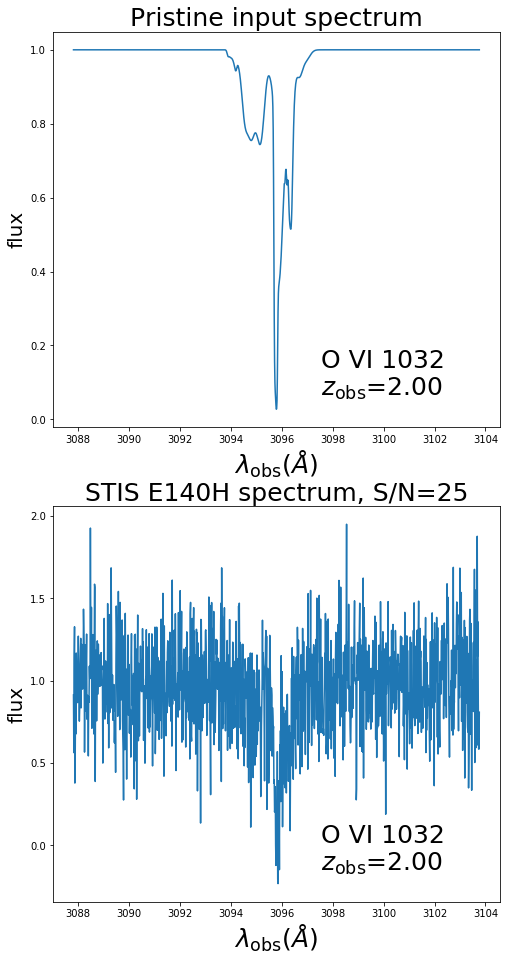

In [11]:
f=pyplot.figure(figsize=(8,16))
simdata=fo['SyntheticData'].data
axi1=f.add_subplot(2,1,2)
axi1.plot(simdata['lam_stis'],simdata['flux_stis'])

axi2=f.add_subplot(2,1,1)
axi2.plot(simdata['lam_stis'],simdata['flux_obs'])

axi1.set_title('STIS E140H spectrum, S/N=25',size=25)
axi1.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=25)
axi1.set_ylabel('flux',size=20)
axi1.annotate(fo['SyntheticData'].header['LINE'],(0.6,0.15),xycoords='axes fraction',size=25)
axi1.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=25)
axi2.set_title('Pristine input spectrum',size=25)
axi2.set_xlabel(r'$\lambda_{\rm obs} (\AA)$',size=25)
axi2.set_ylabel('flux',size=20)
axi2.annotate(fo['SyntheticData'].header['LINE'],(0.6,0.15),xycoords='axes fraction',size=25)
axi2.annotate(r'$z_{\rm obs}$'+'={:4.2f}'.format(fo[3].header['OBS_Z']),(0.6,0.08),xycoords='axes fraction',size=25)

f.savefig(os.path.join(save_location,'asdi2.png'),dpi=300)
pyplot.show()